# PyTorch Experiment Tracking

Author: Yuanjian Liu

Date: 2025-01-19

The purpose of this nodebook is to track the training process of different models to classify food images on the Food101 dataset. We use [EfficientNet series](https://pytorch.org/vision/main/models/efficientnet.html) as the backbone network. We change the classification layer to use transfer learning to fit the [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html).

We will use Tensorboard to visualize the loss and accuracy curves. The notebook is designed to be run in VSCode locally.

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu118
0.17.1+cu118


## 0. Set up device agnostic code, random seeds, and constants

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
import random
def set_seeds(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()

In [4]:
from pathlib import Path
BATCH_SIZE=32
DATA_PATH = Path("data/")
DATA_PATH.mkdir(parents=True, exist_ok=True)

## 1. Download datasets

In [6]:
import os
import zipfile
import requests

def download_data(source:str, destination:str, remove_source: bool = True) -> Path:
    """
    Download a zipped dataset from source and unzips it to the destination
    """
    image_path = DATA_PATH / destination
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the target data
        target_file = Path(source).name # the source is usually a URL
        with open(DATA_PATH / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)
        
        # Unzip the target file
        with zipfile.ZipFile(DATA_PATH / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)
        
        if remove_source:
            os.remove(DATA_PATH / target_file)
    
    return image_path

In [7]:
# Directly download the prepared 10% steak, sushi, pizza dataset zipfile.
# data_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
# download_data(source=data_url, destination="pizza_steak_sushi")

In [8]:
# Download the whole food101 dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

train_data = datasets.Food101(root=DATA_PATH, split="train", download=True)
test_data =  datasets.Food101(root=DATA_PATH, split="test", download=True)
class_names = train_data.classes
print("exmaple classes:", class_names[:10])

exmaple classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [9]:
import shutil
# Sample subsets from the whole food 101 dataset for faster training and comparison
def get_subset(image_path=DATA_PATH / "food-101" / "images",
               metadata_path = DATA_PATH / "food-101" / "meta",
               data_splits=["train", "test"],
               target_classes=["pizza", "steak", "sushi"],
               amount=0.1,
               seed=42):
    # Create target directory path
    label_splits = {}
    num_classes = len(target_classes)
    if num_classes < 5:
        classes_name = '_'.join(target_classes)
    else:
        classes_name = f"{num_classes}_classes"
    target_dir_name = f"{classes_name}_{str(int(amount* 100))}_percent"
    target_dir = DATA_PATH / target_dir_name
    if target_dir.exists():
        print(f"[WARNING] the subset directory already exists, skipping...")
        return None, target_dir

    print(f"Creating directory: '{target_dir_name}'")
    target_dir.mkdir(parents=True, exist_ok=False)

    set_seeds(seed) # defined earlier in the notebook
    for data_split in data_splits:
        print(f"[INFO] Creating image split for {data_split}")
        image_meta_file = metadata_path / f"{data_split}.txt"
        with open(image_meta_file, "r") as f:
            all_image_rel_paths = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]
        
        # Get random subset of target classes image IDs
        number_to_sample = round(amount * len(all_image_rel_paths))
        sampled_image_rel_paths = random.sample(all_image_rel_paths, k=number_to_sample)
        image_paths = [Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_image_rel_paths]
        label_splits[data_split] = image_paths
    
    # Move data to the subset
    for image_split in label_splits.keys():
        for image_path in label_splits[str(image_split)]:
            dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
            if not dest_dir.parent.is_dir():
                dest_dir.parent.mkdir(parents=True, exist_ok=True)
            # print(f"[INFO] Copying {image_path} to {dest_dir}...")
            shutil.copy2(image_path, dest_dir)
    return label_splits, target_dir

### 1.2 Create 10% and 20% dataset files for pizza, steak, sushi

There will be two folders under `data/`, namely `data/pizza_steak_sushi_20_percent` and `data/pizza_steak_sushi_10_percent`.

In [10]:
label_splits, target_dir = get_subset(amount=0.2)
if label_splits is not None:
    num_train_images = len(label_splits["train"])
    num_test_images = len(label_splits["test"])
    print(f"number of images in train dataset: {num_train_images}, number of test_images in test dataset: {num_test_images}")
    label_splits["train"][:10]
print(target_dir)

[WARNING] the subset directory already exists, skipping...
data/pizza_steak_sushi_20_percent


In [11]:
label_splits, target_dir = get_subset(amount=0.1)
if label_splits is not None:
    num_train_images = len(label_splits["train"])
    num_test_images = len(label_splits["test"])
    print(f"number of images in train dataset: {num_train_images}, number of test_images in test dataset: {num_test_images}")
    label_splits["train"][:10]
print(target_dir)

[WARNING] the subset directory already exists, skipping...
data/pizza_steak_sushi_10_percent


In [12]:
train_dir_10_percent = DATA_PATH / "pizza_steak_sushi_10_percent" / "train"
train_dir_20_percent = DATA_PATH / "pizza_steak_sushi_20_percent" / "train"
test_dir = DATA_PATH / "pizza_steak_sushi_20_percent" / "test"  # Share the same test directory
train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi_10_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. Create SummaryWriter() instance for TensorBoard

In [13]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name:str,
                  model_name:str,
                  extra:str=None) -> SummaryWriter:
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y-%m-%d")
    if extra:
        log_dir = Path("runs") / experiment_name / model_name / extra / timestamp
    else:
        log_dir = Path("runs") / experiment_name / model_name / timestamp
    print(f"[INFO] Created summary writer, saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)

example_writer = create_writer(experiment_name="data_10_percent",
                             model_name="effnetb0",
                             extra="5_epochs")
example_writer

[INFO] Created summary writer, saving to: runs/data_10_percent/effnetb0/5_epochs/2025-01-19


## 3. Create feacture extractor model with EfficientNet

In [14]:
from torch import nn
from torchvision import models

def get_efficient_net_model(level: int, num_of_classes: int, device=device):
    possible_levels = set([0, 1, 2, 3, 4, 5, 6, 7])
    if level not in possible_levels:
        print("[ERROR] the provided efficient net level is not in the possible level ranges")
        return
    weight_name = f"EfficientNet_B{level}_Weights"
    model_name = f"efficientnet_b{level}"
    try:
        weights = getattr(models, weight_name).DEFAULT
    except AttributeError:
        raise ValueError(f"[ERROR] The specified weight class '{weight_name}' does not exist!")
    
    model = getattr(models, model_name)(weights=weights).to(device)
    # print("model:", model)
    model.name = model_name
    # print("model features: ", model.features)

    for param in model.features.parameters():
        param.requires_grad = False

    classifier_in_features = model.classifier[1].in_features
    dropout = model.classifier[0]
    model.classifier = nn.Sequential(
        dropout,
        nn.Linear(in_features=classifier_in_features, out_features=num_of_classes, bias=True)
    )
    return model, weights.transforms()

In [35]:
from torchinfo import summary
model_b2, transforms = get_efficient_net_model(level=2, num_of_classes=3)
summary(model_b2,
        input_size=(32, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

## Create experiments

In [44]:
# Create an epoch list
num_epochs = [5, 10]

# Create a model list
model_levels = [0, 2]

# Create a DataLoaders dictionary
data_percentages = [10, 20]

# Target Classes
target_classes=["pizza", "steak", "sushi"]

In [46]:
%%time
from pytorch_modular.utils import save_model
from pytorch_modular.engine import train
from pytorch_modular.data_setup import create_dataloaders
set_seeds(42)

experiment_number = 0

_, target_dir = get_subset(amount=0.2, target_classes=target_classes)
test_dir_20_percent = target_dir / "test"

for data_percentage in data_percentages:
    for model_level in model_levels:
        for num_epoch in num_epochs:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: EfficientNet_B{model_level}")
            print(f"[INFO] Data Percentage: {data_percentage}%")
            print(f"[INFO] Number of Epochs: {num_epoch}")
            _, target_dir = get_subset(amount=data_percentage/100, target_classes=target_classes)
            model, transforms = get_efficient_net_model(level=model_level, num_of_classes=len(target_classes))
            print(f"[INFO] model and transforms created: {model.name}")
            train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=target_dir / "train",
                            test_dir=test_dir_20_percent,
                            transform=transforms,
                            batch_size=BATCH_SIZE)
            print(f"[INFO] train and test data loaders created.")
            # Create a new loss and optimizer for every model
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            # train the model
            train(model=model.to(device), train_dataloader=train_dataloader, test_dataloader=test_dataloader,optimizer=optimizer,
                  loss_fn=loss_fn,epochs=num_epoch,device=device,
                  writer=create_writer(experiment_name=f"{data_percentage}_percent",
                             model_name=model.name,
                             extra=f"{num_epoch}_epochs"))
            
            # Save the model
            save_model_name = f"{model.name}_{data_percentage}_percent_{num_epoch}_epochs.pth"
            save_model(model=model,
                       target_dir="models", model_name=save_model_name)
            print("-" * 50)


[WARNING] the subset directory already exists, skipping...
[INFO] Experiment number: 1
[INFO] Model: EfficientNet_B0
[INFO] Data Percentage: 10%
[INFO] Number of Epochs: 5
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b0
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/10_percent/efficientnet_b0/5_epochs/2025-01-19


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  1.0194 |train_acc:  0.4688 |test_loss:  0.8152 |test_acc:  0.7989


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

Epoch: 2 |train_loss:  0.8552 |train_acc:  0.6250 |test_loss:  0.6685 |test_acc:  0.8784


 40%|████      | 2/5 [00:06<00:08,  2.88s/it]

Epoch: 3 |train_loss:  0.7168 |train_acc:  0.8203 |test_loss:  0.6049 |test_acc:  0.8920


 60%|██████    | 3/5 [00:08<00:04,  2.50s/it]

Epoch: 4 |train_loss:  0.6895 |train_acc:  0.7305 |test_loss:  0.5879 |test_acc:  0.8182


 80%|████████  | 4/5 [00:10<00:02,  2.32s/it]

Epoch: 5 |train_loss:  0.6109 |train_acc:  0.7930 |test_loss:  0.5270 |test_acc:  0.9006


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


[INFO] Saving model to: models/efficientnet_b0_10_percent_5_epochs.pth
--------------------------------------------------
[INFO] Experiment number: 2
[INFO] Model: EfficientNet_B0
[INFO] Data Percentage: 10%
[INFO] Number of Epochs: 10
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b0
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/10_percent/efficientnet_b0/10_epochs/2025-01-19


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  1.0862 |train_acc:  0.3477 |test_loss:  0.8879 |test_acc:  0.7193


 10%|█         | 1/10 [00:02<00:19,  2.12s/it]

Epoch: 2 |train_loss:  0.8865 |train_acc:  0.6836 |test_loss:  0.7305 |test_acc:  0.8795


 20%|██        | 2/10 [00:04<00:16,  2.12s/it]

Epoch: 3 |train_loss:  0.7276 |train_acc:  0.8555 |test_loss:  0.6385 |test_acc:  0.8938


 30%|███       | 3/10 [00:06<00:15,  2.17s/it]

Epoch: 4 |train_loss:  0.7252 |train_acc:  0.6992 |test_loss:  0.5836 |test_acc:  0.8750


 40%|████      | 4/10 [00:08<00:13,  2.20s/it]

Epoch: 5 |train_loss:  0.6502 |train_acc:  0.7148 |test_loss:  0.5628 |test_acc:  0.8574


 50%|█████     | 5/10 [00:11<00:11,  2.25s/it]

Epoch: 6 |train_loss:  0.5544 |train_acc:  0.7969 |test_loss:  0.5158 |test_acc:  0.9068


 60%|██████    | 6/10 [00:13<00:08,  2.25s/it]

Epoch: 7 |train_loss:  0.5859 |train_acc:  0.7773 |test_loss:  0.4969 |test_acc:  0.8881


 70%|███████   | 7/10 [00:15<00:06,  2.25s/it]

Epoch: 8 |train_loss:  0.4948 |train_acc:  0.7891 |test_loss:  0.4735 |test_acc:  0.9136


 80%|████████  | 8/10 [00:17<00:04,  2.30s/it]

Epoch: 9 |train_loss:  0.4918 |train_acc:  0.8203 |test_loss:  0.4569 |test_acc:  0.9256


 90%|█████████ | 9/10 [00:20<00:02,  2.34s/it]

Epoch: 10 |train_loss:  0.4990 |train_acc:  0.8242 |test_loss:  0.4558 |test_acc:  0.9193


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


[INFO] Saving model to: models/efficientnet_b0_10_percent_10_epochs.pth
--------------------------------------------------
[INFO] Experiment number: 3
[INFO] Model: EfficientNet_B2
[INFO] Data Percentage: 10%
[INFO] Number of Epochs: 5
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b2
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/10_percent/efficientnet_b2/5_epochs/2025-01-19


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  1.0522 |train_acc:  0.4141 |test_loss:  0.9167 |test_acc:  0.7602


 20%|██        | 1/5 [00:03<00:15,  3.95s/it]

Epoch: 2 |train_loss:  0.8160 |train_acc:  0.7930 |test_loss:  0.7542 |test_acc:  0.9006


 40%|████      | 2/5 [00:07<00:10,  3.62s/it]

Epoch: 3 |train_loss:  0.7926 |train_acc:  0.6680 |test_loss:  0.6827 |test_acc:  0.9347


 60%|██████    | 3/5 [00:10<00:07,  3.52s/it]

Epoch: 4 |train_loss:  0.7190 |train_acc:  0.7773 |test_loss:  0.6544 |test_acc:  0.9074


 80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

Epoch: 5 |train_loss:  0.5957 |train_acc:  0.9219 |test_loss:  0.6305 |test_acc:  0.8739


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


[INFO] Saving model to: models/efficientnet_b2_10_percent_5_epochs.pth
--------------------------------------------------
[INFO] Experiment number: 4
[INFO] Model: EfficientNet_B2
[INFO] Data Percentage: 10%
[INFO] Number of Epochs: 10
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b2
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/10_percent/efficientnet_b2/10_epochs/2025-01-19


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  1.0481 |train_acc:  0.4453 |test_loss:  0.8999 |test_acc:  0.8023


 10%|█         | 1/10 [00:03<00:32,  3.59s/it]

Epoch: 2 |train_loss:  0.8525 |train_acc:  0.7539 |test_loss:  0.7985 |test_acc:  0.8335


 20%|██        | 2/10 [00:07<00:28,  3.60s/it]

Epoch: 3 |train_loss:  0.7233 |train_acc:  0.7930 |test_loss:  0.6773 |test_acc:  0.9381


 30%|███       | 3/10 [00:11<00:25,  3.71s/it]

Epoch: 4 |train_loss:  0.6503 |train_acc:  0.7812 |test_loss:  0.6243 |test_acc:  0.9170


 40%|████      | 4/10 [00:14<00:22,  3.71s/it]

Epoch: 5 |train_loss:  0.5990 |train_acc:  0.7891 |test_loss:  0.5695 |test_acc:  0.9381


 50%|█████     | 5/10 [00:18<00:18,  3.70s/it]

Epoch: 6 |train_loss:  0.5119 |train_acc:  0.9297 |test_loss:  0.5411 |test_acc:  0.9352


 60%|██████    | 6/10 [00:22<00:14,  3.71s/it]

Epoch: 7 |train_loss:  0.5783 |train_acc:  0.8008 |test_loss:  0.5462 |test_acc:  0.8983


 70%|███████   | 7/10 [00:26<00:11,  3.78s/it]

Epoch: 8 |train_loss:  0.4815 |train_acc:  0.9297 |test_loss:  0.5048 |test_acc:  0.9415


 80%|████████  | 8/10 [00:29<00:07,  3.77s/it]

Epoch: 9 |train_loss:  0.4485 |train_acc:  0.9531 |test_loss:  0.4762 |test_acc:  0.9443


 90%|█████████ | 9/10 [00:33<00:03,  3.78s/it]

Epoch: 10 |train_loss:  0.5009 |train_acc:  0.8359 |test_loss:  0.4592 |test_acc:  0.9136


100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


[INFO] Saving model to: models/efficientnet_b2_10_percent_10_epochs.pth
--------------------------------------------------
[INFO] Experiment number: 5
[INFO] Model: EfficientNet_B0
[INFO] Data Percentage: 20%
[INFO] Number of Epochs: 5
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b0
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/20_percent/efficientnet_b0/5_epochs/2025-01-19


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  0.9632 |train_acc:  0.6042 |test_loss:  0.6727 |test_acc:  0.9097


 20%|██        | 1/5 [00:03<00:14,  3.52s/it]

Epoch: 2 |train_loss:  0.7325 |train_acc:  0.7312 |test_loss:  0.5485 |test_acc:  0.9193


 40%|████      | 2/5 [00:06<00:10,  3.36s/it]

Epoch: 3 |train_loss:  0.5934 |train_acc:  0.8479 |test_loss:  0.4911 |test_acc:  0.8847


 60%|██████    | 3/5 [00:10<00:06,  3.36s/it]

Epoch: 4 |train_loss:  0.5162 |train_acc:  0.8167 |test_loss:  0.4430 |test_acc:  0.8943


 80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

Epoch: 5 |train_loss:  0.4487 |train_acc:  0.8729 |test_loss:  0.3999 |test_acc:  0.9034


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


[INFO] Saving model to: models/efficientnet_b0_20_percent_5_epochs.pth
--------------------------------------------------
[INFO] Experiment number: 6
[INFO] Model: EfficientNet_B0
[INFO] Data Percentage: 20%
[INFO] Number of Epochs: 10
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b0
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/20_percent/efficientnet_b0/10_epochs/2025-01-19


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  0.9659 |train_acc:  0.5813 |test_loss:  0.6732 |test_acc:  0.8818


 10%|█         | 1/10 [00:03<00:30,  3.40s/it]

Epoch: 2 |train_loss:  0.7093 |train_acc:  0.8271 |test_loss:  0.5352 |test_acc:  0.9136


 20%|██        | 2/10 [00:06<00:27,  3.38s/it]

Epoch: 3 |train_loss:  0.5781 |train_acc:  0.7854 |test_loss:  0.4508 |test_acc:  0.9159


 30%|███       | 3/10 [00:10<00:24,  3.47s/it]

Epoch: 4 |train_loss:  0.4680 |train_acc:  0.8750 |test_loss:  0.4166 |test_acc:  0.8977


 40%|████      | 4/10 [00:13<00:20,  3.45s/it]

Epoch: 5 |train_loss:  0.4763 |train_acc:  0.8583 |test_loss:  0.3818 |test_acc:  0.9159


 50%|█████     | 5/10 [00:17<00:17,  3.45s/it]

Epoch: 6 |train_loss:  0.4405 |train_acc:  0.8417 |test_loss:  0.3861 |test_acc:  0.9131


 60%|██████    | 6/10 [00:20<00:13,  3.44s/it]

Epoch: 7 |train_loss:  0.4198 |train_acc:  0.8750 |test_loss:  0.3369 |test_acc:  0.9347


 70%|███████   | 7/10 [00:24<00:10,  3.46s/it]

Epoch: 8 |train_loss:  0.4103 |train_acc:  0.8792 |test_loss:  0.3182 |test_acc:  0.9347


 80%|████████  | 8/10 [00:27<00:06,  3.47s/it]

Epoch: 9 |train_loss:  0.3943 |train_acc:  0.8562 |test_loss:  0.3338 |test_acc:  0.8949


 90%|█████████ | 9/10 [00:31<00:03,  3.57s/it]

Epoch: 10 |train_loss:  0.3075 |train_acc:  0.9062 |test_loss:  0.2908 |test_acc:  0.9284


100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


[INFO] Saving model to: models/efficientnet_b0_20_percent_10_epochs.pth
--------------------------------------------------
[INFO] Experiment number: 7
[INFO] Model: EfficientNet_B2
[INFO] Data Percentage: 20%
[INFO] Number of Epochs: 5
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b2
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/20_percent/efficientnet_b2/5_epochs/2025-01-19


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  0.9352 |train_acc:  0.6208 |test_loss:  0.7586 |test_acc:  0.8369


 20%|██        | 1/5 [00:05<00:21,  5.33s/it]

Epoch: 2 |train_loss:  0.6852 |train_acc:  0.8000 |test_loss:  0.5943 |test_acc:  0.9193


 40%|████      | 2/5 [00:10<00:15,  5.14s/it]

Epoch: 3 |train_loss:  0.5591 |train_acc:  0.9042 |test_loss:  0.4922 |test_acc:  0.9256


 60%|██████    | 3/5 [00:15<00:10,  5.06s/it]

Epoch: 4 |train_loss:  0.4969 |train_acc:  0.8438 |test_loss:  0.4263 |test_acc:  0.9381


 80%|████████  | 4/5 [00:20<00:05,  5.08s/it]

Epoch: 5 |train_loss:  0.4107 |train_acc:  0.9104 |test_loss:  0.3844 |test_acc:  0.9472


100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


[INFO] Saving model to: models/efficientnet_b2_20_percent_5_epochs.pth
--------------------------------------------------
[INFO] Experiment number: 8
[INFO] Model: EfficientNet_B2
[INFO] Data Percentage: 20%
[INFO] Number of Epochs: 10
[WARNING] the subset directory already exists, skipping...
[INFO] model and transforms created: efficientnet_b2
[INFO] train and test data loaders created.
[INFO] Created summary writer, saving to: runs/20_percent/efficientnet_b2/10_epochs/2025-01-19


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss:  0.9661 |train_acc:  0.5667 |test_loss:  0.7465 |test_acc:  0.9222


 10%|█         | 1/10 [00:05<00:46,  5.18s/it]

Epoch: 2 |train_loss:  0.7254 |train_acc:  0.7458 |test_loss:  0.6035 |test_acc:  0.9222


 20%|██        | 2/10 [00:10<00:40,  5.07s/it]

Epoch: 3 |train_loss:  0.6011 |train_acc:  0.8125 |test_loss:  0.5085 |test_acc:  0.9563


 30%|███       | 3/10 [00:15<00:36,  5.20s/it]

Epoch: 4 |train_loss:  0.4953 |train_acc:  0.8729 |test_loss:  0.4252 |test_acc:  0.9688


 40%|████      | 4/10 [00:20<00:31,  5.18s/it]

Epoch: 5 |train_loss:  0.4225 |train_acc:  0.9125 |test_loss:  0.3970 |test_acc:  0.9625


 50%|█████     | 5/10 [00:25<00:25,  5.19s/it]

Epoch: 6 |train_loss:  0.4051 |train_acc:  0.9250 |test_loss:  0.3630 |test_acc:  0.9688


 60%|██████    | 6/10 [00:31<00:20,  5.21s/it]

Epoch: 7 |train_loss:  0.3746 |train_acc:  0.8938 |test_loss:  0.3416 |test_acc:  0.9625


 70%|███████   | 7/10 [00:36<00:15,  5.20s/it]

Epoch: 8 |train_loss:  0.3697 |train_acc:  0.8688 |test_loss:  0.3216 |test_acc:  0.9443


 80%|████████  | 8/10 [00:42<00:10,  5.38s/it]

Epoch: 9 |train_loss:  0.3086 |train_acc:  0.9333 |test_loss:  0.3086 |test_acc:  0.9750


 90%|█████████ | 9/10 [00:47<00:05,  5.43s/it]

Epoch: 10 |train_loss:  0.2963 |train_acc:  0.9104 |test_loss:  0.2871 |test_acc:  0.9443


100%|██████████| 10/10 [00:53<00:00,  5.31s/it]

[INFO] Saving model to: models/efficientnet_b2_20_percent_10_epochs.pth
--------------------------------------------------
CPU times: user 2min 3s, sys: 1min 15s, total: 3min 18s
Wall time: 3min 41s


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./runs

## Load in the best model and make predictions with it

In [15]:
from pathlib import Path
models_path = Path("models")

best_model, transforms = get_efficient_net_model(level=2, num_of_classes=3)
best_model.load_state_dict(torch.load(models_path / "efficientnet_b2_20_percent_10_epochs.pth"))

<All keys matched successfully>

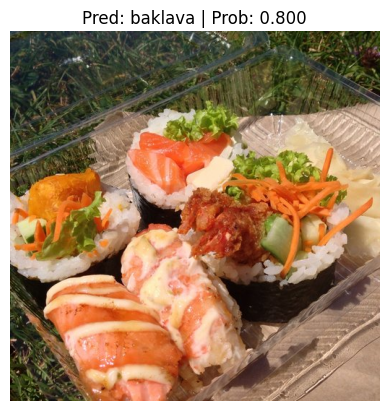

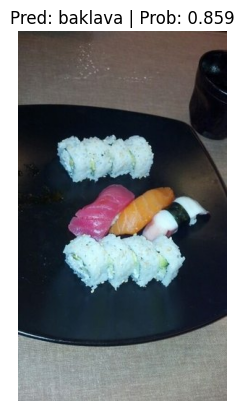

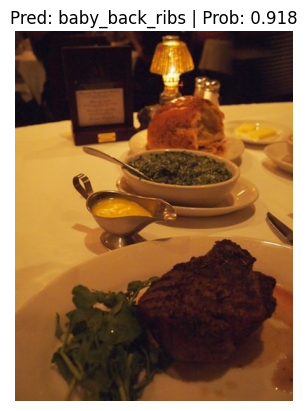

In [16]:
from pytorch_modular.predictions import pred_and_plot_image

import random
num_images_to_plot = 3
test_image_path_list = list((Path("data") / "pizza_steak_sushi_20_percent" / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=transforms)

## The End

We've used transfer learning to compare multiple models and selected the best model for final predictions.